In [ ]:
 """init = [80.1842, 5.8462, 60.9341, 443.7764]
    options = {'reltol': 1e-5}

    odefun = lambda t, y: GI_ode_universal(t, y, odeparams)

    r = ode(odefun)
    r.set_integrator('vode', method='bdf', with_jacobian=False, atol=options['reltol'])
    r.set_initial_value(init, 0)
    r.set_f_params(odeparams)

    # solving the ODE
    t_eval = np.linspace(0, 1440, num=1441)
    y = r.integrate(t_eval)
    init = y[-1, :]

    r.set_initial_value(init, t_eval[-1])
    t_eval = np.linspace(tspan[0], tspan[1], num=tspan[1]-tspan[0]+1)
    y = r.integrate(t_eval)
"""





    #options = {'reltol': 1e-5}


    #odefun = lambda t, y: GI_ode_universal(t, y, odeparams)

    #[t,y] = odeint(GI_ode_universal, init, [0, 1440], args=(odeparams,), rtol=1e-5)
    #init = y[-1]

    #[t, y] = odeint(GI_ode_universal, init, tspan, args=(odeparams,), rtol=1e-5)


    #odefun = lambda t, y: GI_ode_universal(t, y, odeparams)
    #[t,y] = odeint(odefun, init, [0, 1440], args=(odeparams,))


    
    #init = y[-1,:]

    #[t, y] = odeint(GI_ode_universal, tspan, init, args=(odeparams,), options=options)

    #sol = ode(odefun)
    #sol.set_integrator('vode',method='bdf')
    #sol.set_initial_value(init,0)
    #sol.set_f_params(odeparams)
    #sol.integrate(1440)
    #init = sol.y
    #sol.set_initial_value(init,0)
    #sol.integrate(tspan[1])
    #t = sol.t
    #y = sol.y

In [223]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint,ode,solve_ivp,OdeSolver,BDF
import scipy.optimize
from array import array
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

In [321]:
tlist = []
odefluxlist = []
def GI_ode_universal(t, y, p):
    
    Eg0 = 0.0118
    k = 0.4861
    BV = 7200

    b = 1553.6
    Mmax = 1
    alpha_M = 150
    kM = 2
    print(p)
    M = Mmax * y[0] ** kM / (alpha_M ** kM + y[0] ** kM)
    
    OGTT_flux = (int(t >0 ) - int(t > p['t1'])) * t * p['a1'] / p['t1'] +\
     (int(t > p['t1']) - int(t > p['t2'])) * ((t - p['t2']) * (p['a2'] - p['a1']) / (p['t2'] - p['t1']) + p['a2']) +\
      (int(t > p['t2']) - int(t > p['t3'])) * (t - p['t3']) * (p['a3'] - p['a2']) / (p['t3'] - p['t2'])
    OGTTbar = 1
    OGTT_rate = OGTTbar * OGTT_flux

    hepa_bar = 15.443
    hepa_k = 0.27
    hepa_b = -3.54277
    hepa_max = hepa_bar / (hepa_k + p['si']) + hepa_b


    alpha_max = 6
    alpha_k = 0.4
    alpha_b = -0.5
    alpha_HGP = alpha_max / (alpha_k + p['si']) + alpha_b


    HGP_b = 0.104166

    HGP = hepa_max / (alpha_HGP + y[1] * p['hepasi']) + HGP_b


    GF_bar = 4.45
    kGF = 16
    alpha_GF = 260
    shGF = -89
    GF_b = 1.78
    GF = (GF_bar * (y[0] - shGF) ** kGF / (alpha_GF ** kGF + (y[0] - shGF) ** kGF)) + GF_b

    ca_bar = 2
    kca = 4
    alpha_ca = 0.62
    ca_b = 0.07

    ci = ca_bar * (M + p['gamma_bar'] * p['gamma']) ** kca / (alpha_ca ** kca + (M + p['gamma_bar'] * p['gamma']) ** kca) + ca_b

    cmd_factor = 150 
    cmd_b = 0.0635
    cik = 4
    cialpha = 1

    cmd = cmd_factor * ci ** cik / (cialpha ** cik + ci ** cik) + cmd_b

    k1 = 20
    km1 = 100
    r1 = 0.6
    rm1 = 1
    rm2 = 0.001

    r30 = 1.205
    rm3 = 0.0001
    u1 = 2000
    u2 = 3
    u3 = 0.02
    Kp2 = 2.3
    
    ts=60 
    unit_con=0.00069444

    r2 = p['r20'] * ci / (ci + Kp2)
    r3 = p['sigma'] * GF * r30 * ci / (ci + Kp2)
    
    N1_C = km1 / (3 * k1 * cmd + rm1)
    N1_D = r1 / (3 * k1 * cmd + rm1)
    
    N2_E = 3 * k1 * cmd / (2 * k1 * cmd + km1)
    N2_F = 2 * km1 / (2 * k1 * cmd + km1)
    
    N3_L = 2 * k1 * cmd / (2 * km1 + k1 * cmd)
    N3_N = 3 * km1 / (2 * km1 + k1 * cmd)
    
    CN4 = (k1 * cmd / (3 * km1 + u1))
    CN3 = N3_L / (1 - N3_N * CN4)
    CN2 = N2_E / (1 - N2_F * CN3)
    CN1 = N1_D / (1 - N1_C * CN2)
    
    N1 = CN1 * y[2]
    N2 = CN2 * N1
    N3 = CN3 * N2
    N4 = CN4 * N3
    NF = u1 * N4 / u2
    NR = (u2 / u3) * NF
    
    ISR = ts * 9 * (u3 * NR)
    
    dGdt = HGP + OGTT_rate - (Eg0 + unit_con * p['si'] * y[1]) * y[0]
    dIdt = b * ISR / BV - k * y[1]
    
    dN5dt = ts * (rm1 * CN1 * y[2] - (r1 + rm2) * y[2] + r2 * y[3])
    dN6dt = ts * (r3 + rm2 * y[2] - (rm3 + r2) * y[3])
    
    return [dGdt, dIdt, dN5dt, dN6dt]

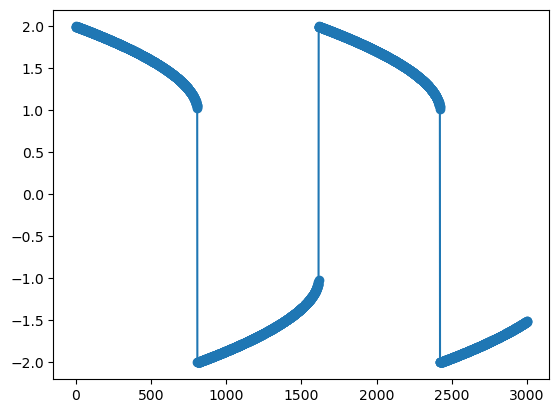

In [322]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def vdp1000(y, t):
    dydt = [y[1], 1000 * (1 - y[0] ** 2) * y[1] - y[0]]
    return dydt

tspan = [0, 3000]
y0 = [2, 0]
t = np.linspace(tspan[0], tspan[1], 3000)
y = odeint(vdp1000, y0, t)


plt.plot(t, y[:, 0], '-o')
plt.show()

In [323]:
def OGTT_cost_function_universal(theta0,theta1, data, costparams, odeparams):

    # Ode solver 
    theta= np.array([theta0,theta1])
    options= {'reltol':1e-5}

    tspan = [data2['t'][0], data2['t'][-1]]


    init=costparams['init']
    
    if any(theta<costparams['LB']) or any(theta>costparams['UB']):

        S=1e6
        true_err=1e6
        return S, true_err, None, None

    import matplotlib.pyplot as plt

    odeparams['sigma']=theta[0]
    odeparams['si']=theta[1]

    odefun = lambda t, y: GI_ode_universal(t, y, odeparams)
    
    te = np.linspace(0,1400,100000)

    #sol = odeint(odefun, init, te, tfirst=True)

    sol = solve_ivp(odefun, (0, 1400),init, rtol = 10**(-5),method='BDF')
    y = sol.y
    t = sol.t

    #plt.plot(t,y[1,:])
    #plt.plot(t,y[2,:])
    #plt.plot(t,y[3,:])
    #plt.plot(t,y[4,:])


    #plt.plot(te, sol[:, 0], '-o')
    #plt.plot(te, sol[:, 1], '-o')

    #plt.plot(te, sol[:, 2], '-o')

    #plt.plot(te, sol[:, 3], '-o')
    plt.plot(t,y[3])

    plt.show()
    

    #sol = solve_ivp(odefun, (0, 1440),init, rtol = 10^(-5), tfirst=True)
    #sol = OdeSolver(odefun, 0, init, 1400, False)
    #y=sol.y
    

    
    init=sol[-1,:]
    te = np.linspace(0,120,3000)
    sol = odeint(odefun,init, te, tfirst=True)

    #sol = solve_ivp(odefun,tspan,init)
    #[t,y] = [sol.t,sol.y]

    #[y,t] = [sol[:,0], sol[:,1]]

    #print("Y value is",sol.y[:,-1])
    #print("Sol.T is",sol.t.shape)

   
    
    

    
    costparams['doPlot'] = False
    if costparams['doPlot']:
        import matplotlib.pyplot as plt
        plt.plot(data2['t'],data2['G'],'x','MarkerSize',10)
        plt.plot(data2['t'],data2['I'],'X','MarkerSize',10) 
        #plt.plot(t,y[:,0])
        plt.plot(te, y[:,0], '-o')
        #plt.plot(t,y[:,1])
        #plt.hold(False)
        plt.show()
    #print("T is",t)
    #print("Y is",y[0])



    #Gpred = np.interp(data2['t'],t,y[0])
    Ginterp = interp1d(t, y[1])  # select the first column of y
    Gpred = Ginterp(data2['t'])
    #print(Gpred)

    Ipred = np.interp(data2['t'],t,y[1])
    #print(Gpred)

    OGTTt=[0, 15, 30, 60, 90, 120]

    Gsim=np.interp(OGTTt,t,y[0])
    Isim=np.interp(OGTTt,t,y[1])
    S=np.sum(costparams['weights_G']*(Gpred-data2['G'])**2 + costparams['weights_I']*(Ipred-data2['I'])**2 )
    true_err=np.sum(  (Gpred-data2['G'])**2 + (Ipred-data2['I'])**2)

    return S, true_err, Gsim, Isim


In [324]:
tdata = [0, 30, 60, 90, 120]
numpts = len(tdata)

data = pd.read_excel('/Users/aaryan/This PC/MS Project/NIH/Meet 8/FWS_OGTT_Combined.xlsx')
outfile = 'FWS_fit_bounds.xlsx'
gdata = data.iloc[:, 8:13]
idata = data.iloc[:,13:14].mean(axis=1).to_frame().join(data.iloc[:,15:19])

odeparams = {
    'a1': 5.99,
    'a2': 2.14,
    'a3': 0.0013,
    't1': 15.60,
    't2': 137.2,
    't3': 258.3,
    'r20': 0.006,
    'hepasi': 1,
    'gamma_bar': 1,
}

# Initial condition for ODE
init = [80.1842, 5.8462, 60.9341, 443.7764]

# Initial condition for fitting

gamma_bar = 1
r20 = 0.006
hepasi = 1

a1 = 8
a2 = 5
a3 = 0

t1 = 15
t2 = 120
t3 = 240

sigma = 1
si = 0.8

theta0 = [sigma, si]

# Parameter bounds
sigmalb = 0.01
sigmaub = 10
silb = 0.01
siub = 3

hepasilb = 0.01
hepasiub = 10
gamma_barlb = -100
gamma_barub = 100

a1lb = 1
a1ub = 20
a2lb = 0.5
a2ub = 10
a3lb = 0
a3ub = 2

t1lb = 5
t1ub = 40
t2lb = 45
t2ub = 200
t3lb = 205
t3ub = 360

r20lb = 0.00006
r20ub = 0.06

LB = [sigmalb, silb]
UB = [sigmaub, siub]

costparams = {
    'init': init,
    'LB': LB,
    'UB': UB,
}

var_G = gdata.std()
var_I = idata.std()

numpar = len(theta0)

results = np.zeros((len(data), 2))
params = np.zeros((len(data), numpar))

0
{'a1': 5.99, 'a2': 2.14, 'a3': 0.0013, 't1': 15.6, 't2': 137.2, 't3': 258.3, 'r20': 0.006, 'hepasi': 1, 'gamma_bar': 1, 'gamma': 0.043750000000000004, 'sigma': 1.0, 'si': 0.8}
{'a1': 5.99, 'a2': 2.14, 'a3': 0.0013, 't1': 15.6, 't2': 137.2, 't3': 258.3, 'r20': 0.006, 'hepasi': 1, 'gamma_bar': 1, 'gamma': 0.043750000000000004, 'sigma': 1.0, 'si': 0.8}
{'a1': 5.99, 'a2': 2.14, 'a3': 0.0013, 't1': 15.6, 't2': 137.2, 't3': 258.3, 'r20': 0.006, 'hepasi': 1, 'gamma_bar': 1, 'gamma': 0.043750000000000004, 'sigma': 1.0, 'si': 0.8}
{'a1': 5.99, 'a2': 2.14, 'a3': 0.0013, 't1': 15.6, 't2': 137.2, 't3': 258.3, 'r20': 0.006, 'hepasi': 1, 'gamma_bar': 1, 'gamma': 0.043750000000000004, 'sigma': 1.0, 'si': 0.8}
{'a1': 5.99, 'a2': 2.14, 'a3': 0.0013, 't1': 15.6, 't2': 137.2, 't3': 258.3, 'r20': 0.006, 'hepasi': 1, 'gamma_bar': 1, 'gamma': 0.043750000000000004, 'sigma': 1.0, 'si': 0.8}
{'a1': 5.99, 'a2': 2.14, 'a3': 0.0013, 't1': 15.6, 't2': 137.2, 't3': 258.3, 'r20': 0.006, 'hepasi': 1, 'gamma_bar': 1

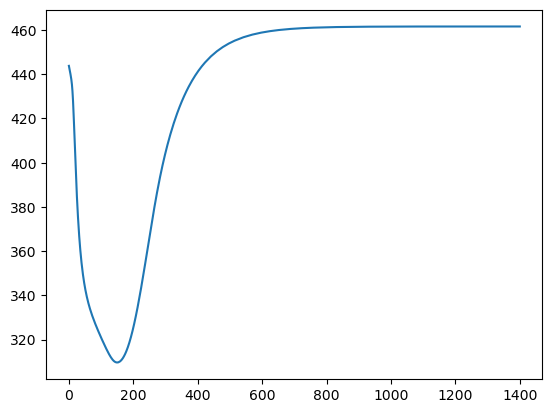

TypeError: unhashable type: 'slice'

In [328]:
#for patientID in range(data.shape[0]):
for patientID in [0]:
    data2 = {}
    data2['t'] = tdata
    data2['G'] = gdata.iloc[patientID,:]
    data2['I'] = idata.iloc[patientID,:]
    
    costparams['weights_G'] = 1/var_G
    costparams['weights_I'] = 1/var_I

    missing1 = np.isnan(data2['G']) 
    missing2 = np.isnan(data2['I'])
    missing = np.array(missing1) * np.array(missing1)

    data2['t'] = np.delete(data2['t'], missing)
    data2['G'] = np.delete(data2['G'], missing)
    data2['I'] = np.delete(data2['I'], missing)
    costparams['weights_G'] = np.delete(costparams['weights_G'], missing)
    costparams['weights_I'] = np.delete(costparams['weights_I'], missing)


    odeparams['gamma'] = 2.5e-6*17500
    print(patientID)
    
    def costfun(theta):
        return OGTT_cost_function_universal(theta[0],theta[1],data2,costparams,odeparams)

    #options = {'disp': True}
    #res = minimize(costfun, theta0, bounds=list(zip(LB, UB)), method='SLSQP', options=options)
    #print("COSTFUN Out",costfun([1,0.8]))

    res = scipy.optimize.fmin(func = costfun,x0=[1,0.8])
    
    #print(res)
    paramin = res
    
    #print("Estimated parameters sigma si:")
    #print(paramin)
    
    wrss, true_error, gsim, isim = OGTT_cost_function_universal(paramin[0],paramin[1], data2, costparams, odeparams)
    
    params[patientID,:] = paramin
    
    ss = np.nansum(data2['G']**2) + np.nansum(data2['I']**2)
    rsq = 1 - true_error/ss
    aic = 2*numpar + numpts*np.log(numpts*wrss)
    results[patientID] = [paramin[0],paramin[1]]
    
    #print("Final results: (WRSS, true_error, RSQ, AIC)")
    #print([wrss, true_error, rsq, aic])

results_df = pd.DataFrame(results, columns = ['sigma','si'])
covartab = pd.DataFrame(data[['subject']])

final_df = pd.concat([covartab, results_df], axis=1)
final_df.to_excel(outfile)
np.save('fit_params.npy', params)


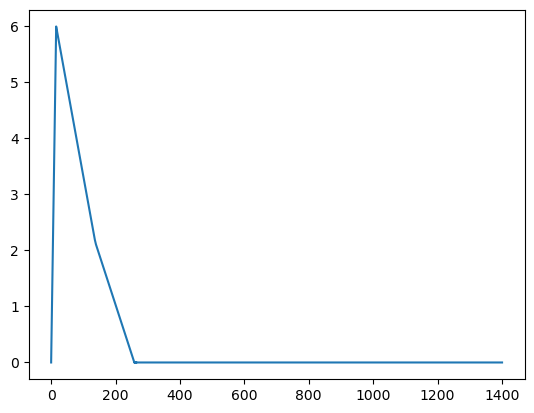

In [310]:
plt.plot(tlist,odefluxlist)
plt.show()